In [1]:
import pandas as pd
import numpy as np
import sys, os, re
from numba import njit, typed
from numba.experimental import jitclass

if re.match(r'^(\w\:\\)|(/)', os.getcwd()):
    sys.path.insert(0, "c:/Users/dmitr/devs/quantl/")
    sys.path.insert(0, "c:/Users/dmitr/devs/Qube2exp/src/")
    sys.path.insert(0, "c:/Users/dmitr/devs/Qube/")
    print('installed')

installed


# First experiments

In [33]:
# Time data representation
from qube.quantitative.ta.indicators import ema, _calc_ema
from qube.quantitative.tools import apply_to_frame
import matplotlib.pylab as plt

from quantl.core import Indicator
from quantl.impl.indicators import Sma, Ema
from quantl.utils import nans

In [10]:
T = pd.date_range('2024-01-01 00:00', freq='1Min', periods=100_000)
ds = 1 + (2*np.random.randn(len(T))).cumsum()
data = list(zip(T, ds))

In [39]:
x0 = pd.Series(ds, T).resample('1H').last()

e0 = Ema(100, init_mean=1)
for t,v in zip(x0.index, x0.values):
    e0.update(v, t)

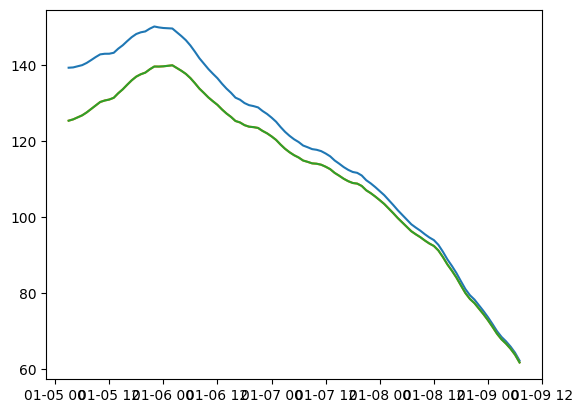

In [55]:
# plt.plot(x0)
plt.plot(x0.ewm(span=100, min_periods=100).mean()[:200])
plt.plot(pd.Series(e0.to_dict()['ema(100,1)'])[:200])
plt.plot(apply_to_frame(ema, x0, 100)[:200])

In [131]:
class SmaNu(Indicator):
    """
    Simple moving average
    """
    def __init__(self, period):
        super().__init__()
        self.period = period
        self.__s = nans(period)
        self.__i = typed.List([0])
        self._name = 'sma(%d)' % period
        self._calculate = self.wrap(period) 

    def wrap(cls, period):
        @njit
        def _do_calc(x, _is_being_appended, __s, __i):
            _x = x / period
            __s[__i[0]] = _x

            if _is_being_appended:
                __i[0] += 1
                if __i[0] >= period:
                    __i[0] = 0

            return np.sum(__s)
        return _do_calc

    def calculate(self, x):
        # print(self.__s)
        return self._calculate(
            x, self._is_being_appended, self.__s, self.__i
        )

In [215]:
class EmaFast(Indicator):
    def __init__(self, period, init_mean=True):
        super().__init__()
        self.period = period
        self.init_mean = init_mean
        self._name = 'ema(%d,%s)' % (period, init_mean)
        self.xs = [] 
        self.xc = np.arange(1500).reshape(-1, 1)

    def calculate(self, x):
        # self.xs.append(x)
        # xc = np.array(self.xs).reshape(-1, 1)
        # return 0
        return _calc_ema(self.xc, self.period, self.init_mean)[-1][0]

In [3]:
%%timeit

e0 = Ema(15)
for i in range(1500):
    e0.update(i, i)

2.47 ms ± 438 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [216]:
%%timeit

e1 = EmaFast(15)
for i in range(1500):
    e1.update(i, i)

16.7 ms ± 559 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [154]:
%%timeit

sma1 = SmaNu(15)
for i in range(1000):
    sma1.update(i, float(i))

116 ms ± 4.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [148]:
%%timeit
sma0 = Sma(15)
for i in range(1000):
    sma0.update(i, i)

4.27 ms ± 329 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Temporal data representation

In [8]:
%load_ext autoreload
%autoreload 2

from qube.core.series import  recognize_time,  FloatSeries, Float, Trade, Sma

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Series experiments

In [12]:
# %%timeit
fs = FloatSeries('close', '10Min')
fs.update(Float(recognize_time('2024-01-01 00:00'), 1))
fs.update(Float(recognize_time('2024-01-01 00:01'), 2))
fs.update(Float(recognize_time('2024-01-01 00:12'), 3))
fs.update(Float(recognize_time('2024-01-01 00:21'), 4))
fs.update(Float(recognize_time('2024-01-01 00:22'), 5))
fs.update(Float(recognize_time('2024-01-01 00:31'), 6))
fs.update(Float(recognize_time('2024-01-01 00:33'), 7))
fs.update(Trade(recognize_time('2024-01-01 00:45'), 12, 100))
fs.update(Trade(recognize_time('2024-01-01 00:55'), 12, 100))

True

In [13]:
print(str(fs))

close[10 minutes] | 6 records
  [2024-01-01T00:50:00]	12
  [2024-01-01T00:40:00]	12
  [2024-01-01T00:30:00]	7
   .......... 
  [2024-01-01T00:20:00]	5
  [2024-01-01T00:10:00]	3
  [2024-01-01T00:00:00]	2



In [16]:
T = pd.date_range('2020-01-01 00:00', freq='5Min', periods=50000)

In [17]:
# %%timeit
s0 = Sma(3)
fs = FloatSeries('close', '10Min').attach(s0)
[fs.update(Float(ti, vi)) for ti, vi in zip(T, range(len(T)))];

In [18]:
print(str(fs))

close[10 minutes] | 25000 records
  [2020-06-22T14:30:00]	49999
  [2020-06-22T14:20:00]	49997
  [2020-06-22T14:10:00]	49995
   .......... 
  [2020-01-01T00:20:00]	5
  [2020-01-01T00:10:00]	3
  [2020-01-01T00:00:00]	1



In [ ]:
print(str(s0._values))

In [256]:
fs = FloatSeries('Test', '10Min')

In [257]:
s0 = Sma(3)
fs.attach(s0)

In [258]:
fs.update(Float(recognize_time('2024-01-01 00:00'), 1))
fs.update(Float(recognize_time('2024-01-01 00:01'), 2))
fs.update(Float(recognize_time('2024-01-01 00:12'), 3))
fs.update(Float(recognize_time('2024-01-01 00:21'), 4))
fs.update(Float(recognize_time('2024-01-01 00:22'), 5))
fs.update(Float(recognize_time('2024-01-01 00:31'), 6))
fs.update(Float(recognize_time('2024-01-01 00:33'), 7))
fs.update(Trade(recognize_time('2024-01-01 00:45'), 12, 100))
fs.update(Trade(recognize_time('2024-01-01 00:55'), 12, 100))

True

In [259]:
print(str(s0._values))

sma(3)[10 minutes] | 6 records
  [2024-01-01T00:50:00]	10.333333333333334
  [2024-01-01T00:40:00]	8.0
  [2024-01-01T00:30:00]	5.0
   .......... 
  [2024-01-01T00:20:00]	3.333333333333333
  [2024-01-01T00:10:00]	nan
  [2024-01-01T00:00:00]	nan

